In [ ]:
!pip install xgboost catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.shape, test.shape


((104000, 35), (25889, 34))

In [ ]:
print(train.head())
print("\n--- INFO ---")
print(train.info())
print("\n--- Missing Values ---")
print(train.isna().sum())
print("\n--- Describe (numerical) ---")
print(train.describe())


         id player_id  friend_count  social_interactions  guild_membership  \
0  PLY00001   P007453         140.0                 39.0               NaN   
1  PLY00002   P120776         126.0                 12.0               1.0   
2  PLY00003   P083055         157.0                 63.0               1.0   
3  PLY00004   P087827          89.0                 96.0               1.0   
4  PLY00005   P045133         159.0                 80.0               0.0   

   event_participation_rate  daily_login_streak  avg_session_length  \
0                 35.495321                86.0           94.186687   
1                 35.222611                27.0           76.694036   
2                 54.291374                 1.0           66.680997   
3                 52.990011                74.0           75.864572   
4                 78.586509                84.0           33.774836   

   sessions_per_week  total_playtime_hours  ...  purchase_frequency  \
0          20.660400            7

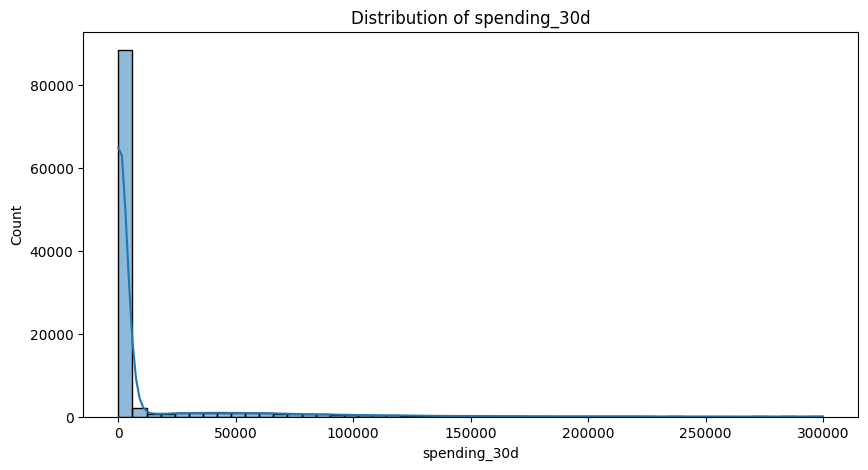

Zero spending count: 50132
Zero spending percentage: 0.4820384615384615


In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(train['spending_30d'], bins=50, kde=True)
plt.title("Distribution of spending_30d")
plt.show()

print("Zero spending count:", (train['spending_30d'] == 0).sum())
print("Zero spending percentage:", (train['spending_30d'] == 0).mean())


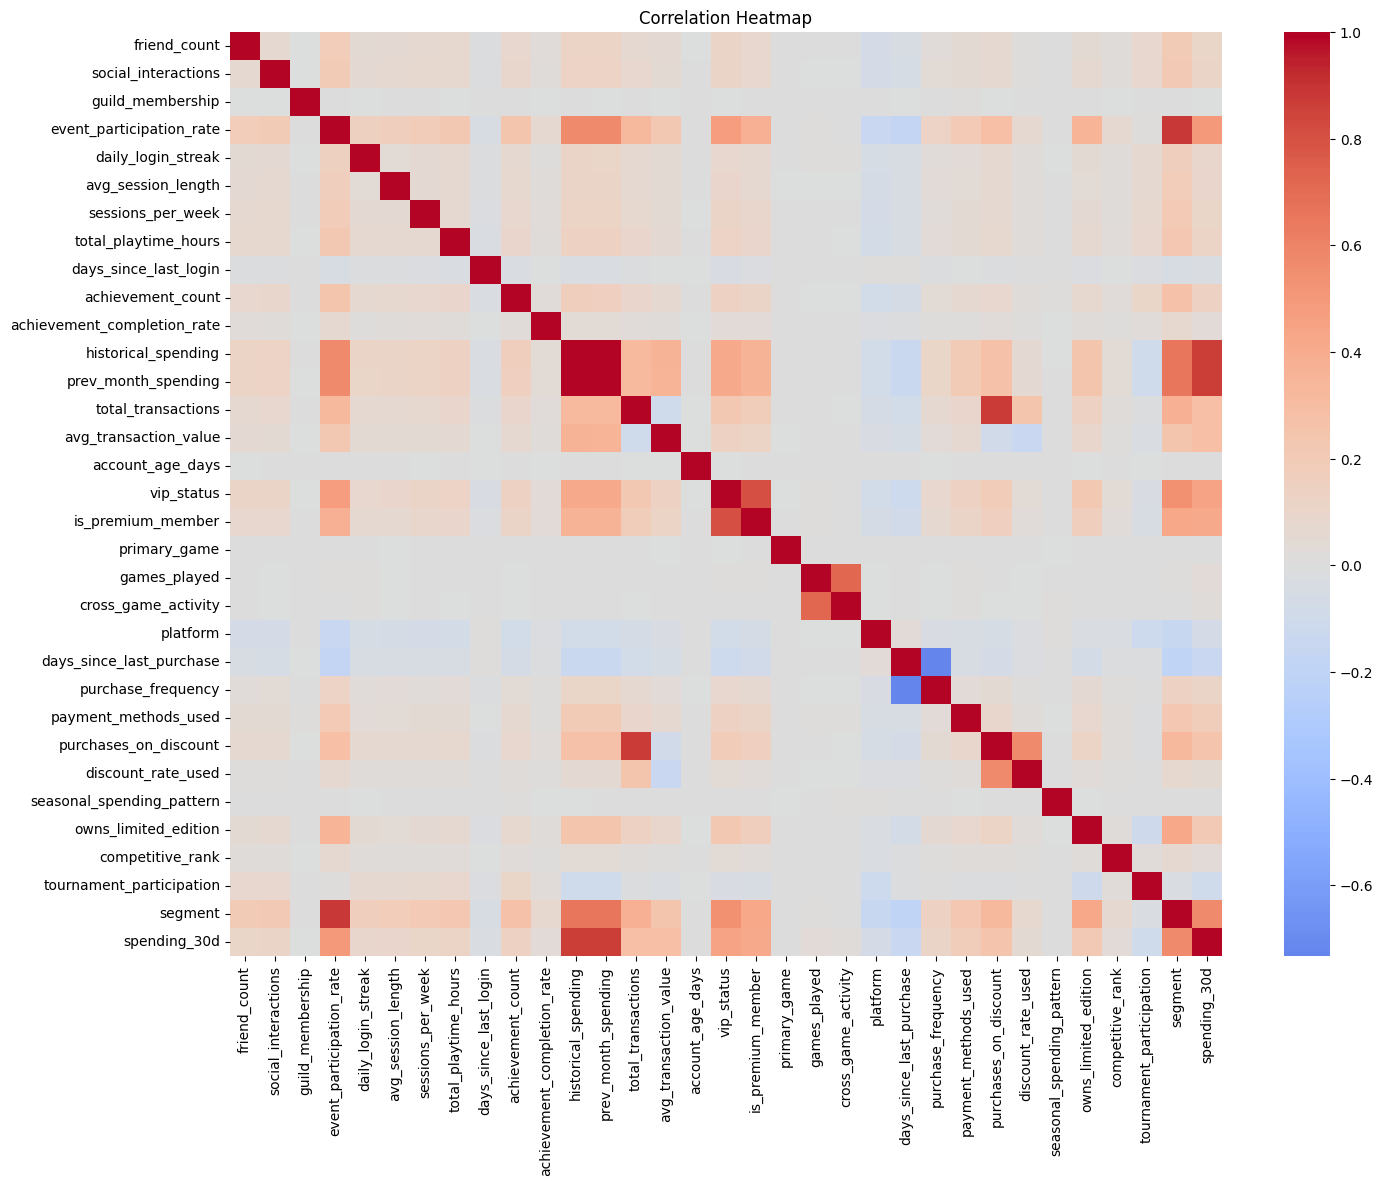

,spending_30d
spending_30d,1.000000
historical_spending,0.868204
prev_month_spending,0.865581
segment,0.568803
event_participation_rate,0.497855
vip_status,0.447114
is_premium_member,0.417903
avg_transaction_value,0.287226
total_transactions,0.286096
purchases_on_discount,0.250172


In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(train.drop(['id', 'player_id'], axis=1).corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

train.drop(['id', 'player_id'], axis=1).corr()['spending_30d'].sort_values(ascending=False).head(15)

In [ ]:
skew_vals = train.drop(columns=['spending_30d', 'id', 'player_id']).skew().sort_values(ascending=False)
print(skew_vals.head(20))

avg_transaction_value       32.693155
prev_month_spending          3.246635
historical_spending          3.199734
tournament_participation     2.897423
owns_limited_edition         2.564573
is_premium_member            1.999533
cross_game_activity          1.551818
vip_status                   1.162282
payment_methods_used         0.994133
purchases_on_discount        0.968385
days_since_last_login        0.941525
games_played                 0.901302
purchase_frequency           0.619384
days_since_last_purchase     0.618072
daily_login_streak           0.515226
segment                      0.498825
total_transactions           0.484470
avg_session_length           0.483627
event_participation_rate     0.428634
friend_count                 0.412971
dtype: float64


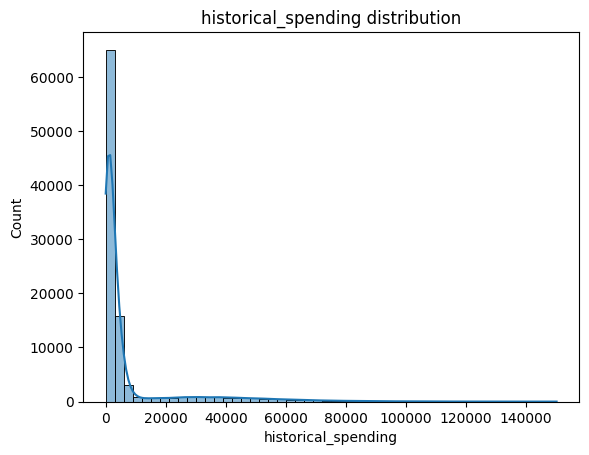

In [ ]:
sns.histplot(train['historical_spending'], bins=50, kde=True)
plt.title("historical_spending distribution")
plt.show()


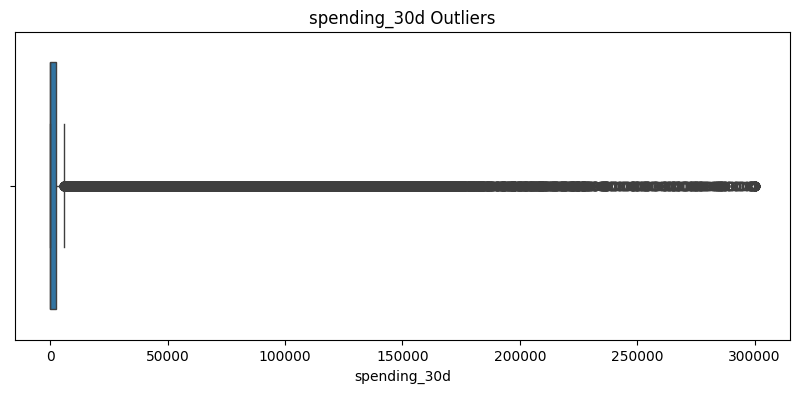

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train['spending_30d'])
plt.title("spending_30d Outliers")
plt.show()


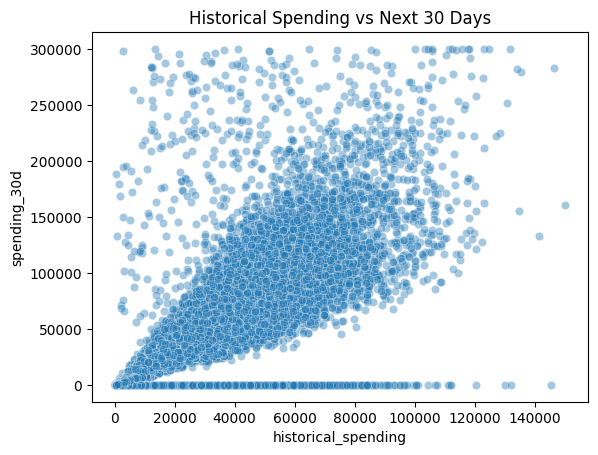

In [ ]:
sns.scatterplot(x=train['historical_spending'],
                y=train['spending_30d'],
                alpha=0.4)
plt.title("Historical Spending vs Next 30 Days")
plt.show()


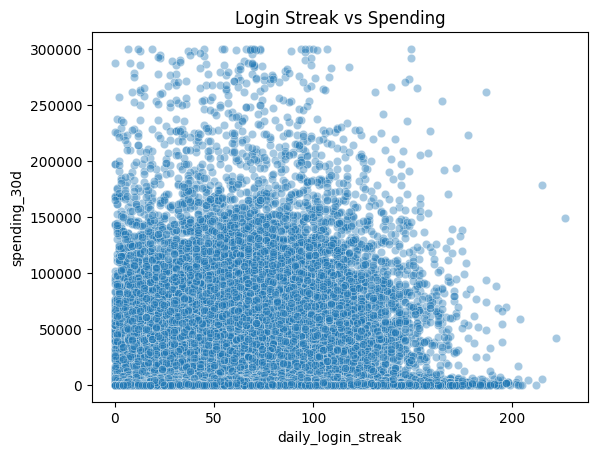

In [ ]:
sns.scatterplot(x=train['daily_login_streak'],
                y=train['spending_30d'],
                alpha=0.4)
plt.title("Login Streak vs Spending")
plt.show()


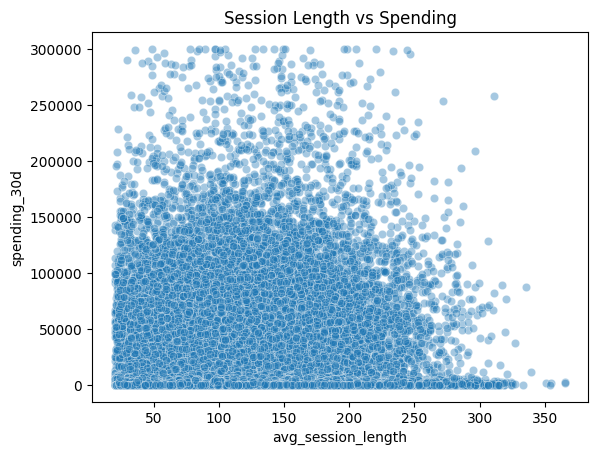

In [ ]:
sns.scatterplot(x=train['avg_session_length'],
                y=train['spending_30d'],
                alpha=0.4)
plt.title("Session Length vs Spending")
plt.show()


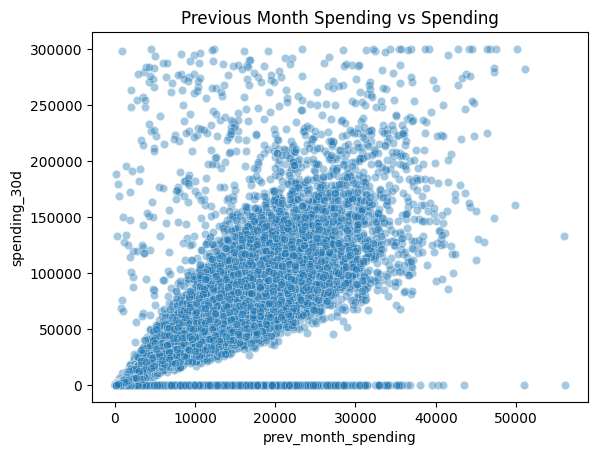

In [ ]:
sns.scatterplot(x=train['prev_month_spending'],
                y=train['spending_30d'],
                alpha=0.4)
plt.title("Previous Month Spending vs Spending")
plt.show()


In [ ]:
cat_cols = ['primary_game', 'platform', 'segment']

for col in cat_cols:
    print(f"\n=== {col} value counts ===")
    print(train[col].value_counts())



=== primary_game value counts ===
primary_game
2.0    19738
3.0    19566
0.0    19565
1.0    19517
4.0    19446
Name: count, dtype: int64

=== platform value counts ===
platform
1.0    51365
0.0    36838
2.0     9702
Name: count, dtype: int64

=== segment value counts ===
segment
0.0    39176
1.0    24646
2.0    19567
3.0    14542
Name: count, dtype: int64


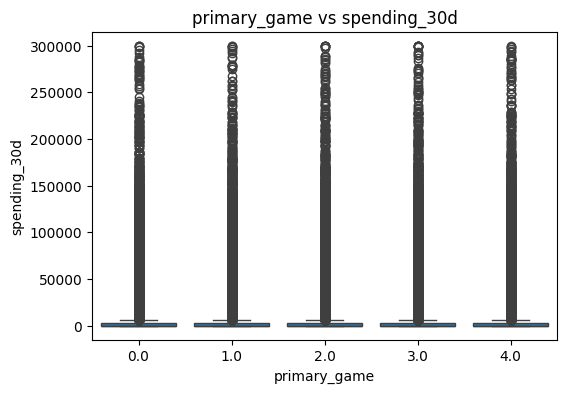

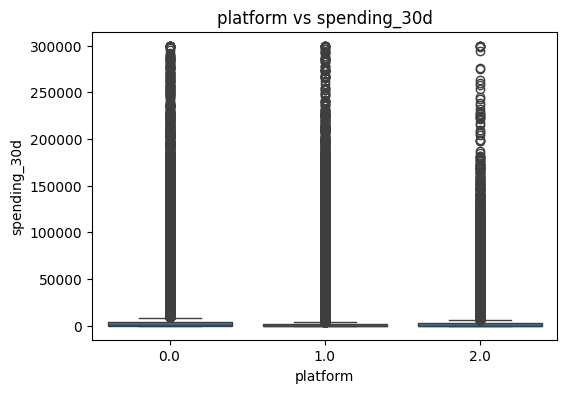

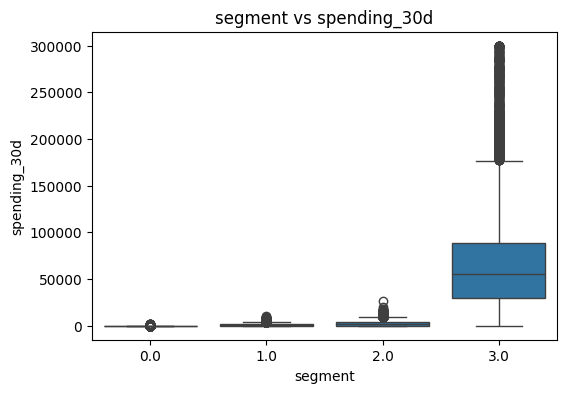

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=train[col], y=train['spending_30d'])
    plt.title(f"{col} vs spending_30d")
    plt.show()


In [ ]:
train['is_spender'] = (train['spending_30d'] > 0).astype(int)


In [ ]:
spender_means = train.groupby('is_spender').mean(numeric_only=True).T
spender_means['diff'] = spender_means[1] - spender_means[0]
spender_means.sort_values('diff', ascending=False).head(15)

is_spender,0,1,diff
spending_30d,0.000000,20019.977627,20019.977627
historical_spending,2216.305406,12131.919983,9915.614577
prev_month_spending,778.192524,4250.123361,3471.930838
avg_transaction_value,114.890919,366.521201,251.630282
total_playtime_hours,559.426867,628.813201,69.386334
achievement_count,150.362403,171.898477,21.536074
event_participation_rate,31.685188,46.883390,15.198202
friend_count,104.348436,116.817571,12.469135
avg_session_length,105.021889,115.165780,10.143891
total_transactions,35.935648,44.449427,8.513779


Data preparation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

print("Before imputation:")
print(train.isna().sum())


EXCLUDED_FROM_SIMPLE_IMPUTATION = ["id", "player_id", "spending_30d", "segment"]

categorical_cols = [
    "primary_game", "platform",
    "is_premium_member", "guild_membership"
]

categorical_cols = [c for c in categorical_cols if c in train.columns and c not in EXCLUDED_FROM_SIMPLE_IMPUTATION]

numeric_cols = [
    c for c in train.columns
    if c not in categorical_cols
    and c not in EXCLUDED_FROM_SIMPLE_IMPUTATION
]

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

train[numeric_cols] = num_imputer.fit_transform(train[numeric_cols])
test[numeric_cols]  = num_imputer.transform(test[numeric_cols])

if len(categorical_cols) > 0:
    train[categorical_cols] = cat_imputer.fit_transform(train[categorical_cols])
    test[categorical_cols]  = cat_imputer.transform(test[categorical_cols])

print("\nAfter imputation:")
print(train.isna().sum())

Before imputation:
id                                0
player_id                         0
friend_count                   6046
social_interactions            6106
guild_membership               6028
event_participation_rate       6001
daily_login_streak             6107
avg_session_length             6028
sessions_per_week              6162
total_playtime_hours           6132
days_since_last_login          6040
achievement_count              6011
achievement_completion_rate    6061
historical_spending            6099
prev_month_spending            5969
total_transactions             6133
avg_transaction_value          6031
account_age_days               6102
vip_status                     6094
is_premium_member              6021
primary_game                   6168
games_played                   5985
cross_game_activity            6083
platform                       6095
days_since_last_purchase       6148
purchase_frequency             5995
payment_methods_used           6108
purchases

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

seg_known = train[train["segment"].notna()]
seg_missing = train[train["segment"].isna()]

print("Known segment rows:", len(seg_known))
print("Missing segment rows:", len(seg_missing))

feature_cols = [
    c for c in train.columns
    if c not in ["id", "player_id", "segment", "spending_30d"]
]

X = seg_known[feature_cols]
y = seg_known["segment"].astype(int)

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42
)
clf.fit(X, y)

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_tr, y_tr)
preds = clf.predict(X_val)

print("\n=== Segment Prediction Model Report ===")
print(classification_report(y_val, preds))

Known segment rows: 97931
Missing segment rows: 6069

=== Segment Prediction Model Report ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7842
           1       0.83      0.87      0.85      4959
           2       0.87      0.79      0.83      3891
           3       0.99      0.96      0.97      2895

    accuracy                           0.91     19587
   macro avg       0.91      0.90      0.91     19587
weighted avg       0.91      0.91      0.91     19587


After model-based imputation:
0


/tmp/ipython-input-3241449292.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_missing["segment"] = clf.predict(seg_missing[feature_cols])


In [ ]:
if len(seg_missing) > 0:
    seg_missing_copy = seg_missing.copy()
    seg_missing_copy["segment"] = clf.predict(seg_missing_copy[feature_cols])
    train.loc[train["segment"].isna(), "segment"] = seg_missing_copy["segment"]

print("\nAfter model-based imputation:")
print(train["segment"].isna().sum())


After model-based imputation:
0


In [ ]:
train.head(100)

,id,player_id,friend_count,social_interactions,guild_membership,event_participation_rate,daily_login_streak,avg_session_length,sessions_per_week,total_playtime_hours,...,purchase_frequency,payment_methods_used,purchases_on_discount,discount_rate_used,seasonal_spending_pattern,owns_limited_edition,competitive_rank,tournament_participation,segment,spending_30d
0,PLY00001,P007453,140.0,39.0,1.0,35.495321,86.0,94.186687,20.660400,793.043827,...,9.741494,1.0,1.0,0.250000,4.0,0.0,7.0,1.0,1.0,0.00
1,PLY00002,P120776,126.0,12.0,1.0,35.222611,27.0,76.694036,15.112974,836.397667,...,11.193590,1.0,25.0,0.581395,5.0,0.0,3.0,0.0,1.0,0.00
2,PLY00003,P083055,157.0,63.0,1.0,54.291374,1.0,66.680997,13.770480,561.212807,...,5.175272,3.0,27.0,0.551020,7.0,0.0,5.0,0.0,1.0,0.00
3,PLY00004,P087827,89.0,96.0,1.0,52.990011,74.0,75.864572,11.941930,584.461687,...,10.374656,2.0,22.0,0.536585,6.0,0.0,9.0,0.0,2.0,2223.70
4,PLY00005,P045133,159.0,80.0,0.0,78.586509,84.0,33.774836,1.405901,617.041867,...,9.741494,3.0,11.0,0.261905,0.0,1.0,4.0,0.0,3.0,156634.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,PLY00096,P075396,58.0,98.0,0.0,41.046221,65.0,192.285463,16.613125,926.230397,...,7.419296,1.0,11.0,0.200000,1.0,0.0,8.0,0.0,1.0,2006.16
96,PLY00097,P022557,125.0,21.0,1.0,36.051588,56.0,116.295168,25.353211,745.507530,...,11.294522,3.0,19.0,0.372549,6.0,0.0,5.0,0.0,1.0,0.00
97,PLY00098,P002159,169.0,75.0,1.0,66.098282,66.0,105.664336,16.230469,922.808724,...,7.257828,2.0,26.0,0.440678,9.0,1.0,5.0,0.0,2.0,4392.18
98,PLY00099,P107600,77.0,86.0,1.0,49.641273,38.0,171.404939,15.055533,799.931967,...,1.907537,1.0,17.0,0.515152,5.0,0.0,4.0,1.0,1.0,0.00


Model

In [ ]:
import numpy as np

log_cols = [
    "historical_spending",
    "prev_month_spending",
    "avg_transaction_value",
    "tournament_participation",
    "owns_limited_edition",
    "cross_game_activity",
    "is_premium_member",
    "payment_methods_used",
]

log_cols = [c for c in log_cols if c in train.columns]

print("Log-transforming these columns:", log_cols)

for col in log_cols:
    train[col] = np.log1p(train[col])
    test[col]  = np.log1p(test[col])

train["spending_30d_log"] = np.log1p(train["spending_30d"])

print("\nCreated new target column: spending_30d_log")


Log-transforming these columns: ['historical_spending', 'prev_month_spending', 'avg_transaction_value', 'tournament_participation', 'owns_limited_edition', 'cross_game_activity', 'is_premium_member', 'payment_methods_used']

Created new target column: spending_30d_log


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_absolute_error
import lightgbm as lgb

train["is_spender"] = (train["spending_30d"] > 0).astype(int)

drop_cols = ["id", "player_id", "spending_30d", "spending_30d_log", "is_spender"]
features = [c for c in train.columns if c not in drop_cols]

print("Number of features:", len(features))

X_cls = train[features]
y_cls = train["is_spender"]


Number of features: 32


In [ ]:
# Split for validation
Xc_train, Xc_val, yc_train, yc_val = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

clf = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

clf.fit(Xc_train, yc_train)

val_proba = clf.predict_proba(Xc_val)[:, 1]

# Search best threshold
best_t = 0.5
best_f1 = -1

for t in np.linspace(0.1, 0.9, 17):
    preds = (val_proba > t).astype(int)
    score = f1_score(yc_val, preds)
    if score > best_f1:
        best_f1 = score
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4601
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
Best threshold: 0.35
Best F1: 0.7410481384870761


In [ ]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

# Use only spenders for regression (log target)
spender_mask = train["is_spender"] == 1
X_reg = train.loc[spender_mask, features]
y_reg = train.loc[spender_mask, "spending_30d_log"]  # log target

Xr_train, Xr_val, yr_train, yr_val = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# --- 1) LightGBM Regressor ---
lgb_reg = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# --- 2) XGBoost Regressor ---
xgb_reg = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
)

# --- 3) CatBoost Regressor ---
cat_reg = CatBoostRegressor(
    depth=8,
    learning_rate=0.03,
    n_estimators=800,
    loss_function="RMSE",
    random_state=42,
    verbose=0
)

# Train all three
lgb_reg.fit(Xr_train, yr_train)
xgb_reg.fit(Xr_train, yr_train)
cat_reg.fit(Xr_train, yr_train)

# Validation predictions (convert back from log)
val_pred_lgb_log = lgb_reg.predict(Xr_val)
val_pred_xgb_log = xgb_reg.predict(Xr_val)
val_pred_cat_log = cat_reg.predict(Xr_val)

val_true = np.expm1(yr_val)
val_pred_lgb = np.expm1(val_pred_lgb_log)
val_pred_xgb = np.expm1(val_pred_xgb_log)
val_pred_cat = np.expm1(val_pred_cat_log)

# Simple average ensemble
val_pred_ens = (val_pred_lgb + val_pred_xgb + val_pred_cat) / 3.0

mae_lgb = mean_absolute_error(val_true, val_pred_lgb)
mae_xgb = mean_absolute_error(val_true, val_pred_xgb)
mae_cat = mean_absolute_error(val_true, val_pred_cat)
mae_ens = mean_absolute_error(val_true, val_pred_ens)

print("MAE LGBM:", mae_lgb)
print("MAE XGB:", mae_xgb)
print("MAE Cat:", mae_cat)
print("MAE Ensemble:", mae_ens)
print("NMAE Ensemble (approx):", mae_ens / np.mean(val_true))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4591
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 32
[LightGBM] [Info] Start training from score 7.939081
MAE LGBM: 3517.457211287501
MAE XGB: 3591.525904658227
MAE Cat: 3414.8206409032296
MAE Ensemble: 3462.6019639527008
NMAE Ensemble (approx): 0.16992499564893226


In [ ]:

clf.fit(X_cls, y_cls)

X_reg_full = X_reg
y_reg_full = y_reg

lgb_reg.fit(X_reg_full, y_reg_full)
xgb_reg.fit(X_reg_full, y_reg_full)
cat_reg.fit(X_reg_full, y_reg_full)

X_test = test[features]

# Stage 1: spender probability + best threshold
test_proba = clf.predict_proba(X_test)[:, 1]
test_is_spender = (test_proba > best_t).astype(int)

# Stage 2: ensemble prediction in log space
test_pred_lgb_log = lgb_reg.predict(X_test)
test_pred_xgb_log = xgb_reg.predict(X_test)
test_pred_cat_log = cat_reg.predict(X_test)

test_pred_lgb = np.expm1(test_pred_lgb_log)
test_pred_xgb = np.expm1(test_pred_xgb_log)
test_pred_cat = np.expm1(test_pred_cat_log)

test_pred_ens = (test_pred_lgb + test_pred_xgb + test_pred_cat) / 3.0

test_spend_final = np.where(test_is_spender == 1, test_pred_ens, 0.0)


[LightGBM] [Info] Number of positive: 53868, number of negative: 50132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4614
[LightGBM] [Info] Number of data points in the train set: 104000, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517962 -> initscore=0.071877
[LightGBM] [Info] Start training from score 0.071877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4600
[LightGBM] [Info] Number of data points in the train set: 53868, number of used features: 32
[LightGBM] [Info] Start training from score 7.942489


In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub["task3"] = test_spend_final
sub.to_csv("submission_task3_ensemble_two_stage.csv", index=False)

print("Saved submission_task3_ensemble_two_stage.csv")


Saved submission_task3_ensemble_two_stage.csv
